In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml
from classy import Class
from iminuit import minimize as minuit

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

In [3]:
from pybird.correlator import Correlator
from pybird.io_pb import ReadWrite
from pybird.likelihood import Likelihood

# Data format for EFT likelihood

The best way to understand what is the format of the data read by the EFT likelihood is to construct one. 

Let us construct a fake data from an EFT prediction. 

In [4]:
datadir = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'pybird', 'data')

### Setting the EFT prediction

Redshift?

In [5]:
z = 0.57

First, we create a CLASS engine M, that will be provided to the PyBird correlator engine. 

In [6]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()

In [7]:
from scipy.interpolate import interp1d
kk = np.logspace(-5, 0, 200)
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 
ipk_lin = interp1d(kk, pk_lin, kind='cubic')

In [8]:
f1 = M.scale_independent_growth_factor_f(z)

We need some distortion (AP) parameters.

In [9]:
H_ap, D_ap = M.Hubble(z) / M.Hubble(0.), M.angular_distance(z) * M.Hubble(0.)

In [10]:
M_fid = Class()
cosmo_ap = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.6776, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M_fid.set(cosmo_ap)
M_fid.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M_fid.compute()

Omega_m_fid = M_fid.Omega_m()
H_fid, D_fid = M_fid.Hubble(z) / M_fid.Hubble(0.), M_fid.angular_distance(z) * M_fid.Hubble(0.)

print ('Omega_m_fid: %.3f' % Omega_m_fid)

Omega_m_fid: 0.310


Next, we create a PyBird Correlator engine N.

In [11]:
dk = 0.01
kd = np.arange(0.005, 0.3, dk)

In [12]:
N = Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'z': z, 'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 'kmax': 0.3, 'xdata': kd, 
       'eft_basis': 'eftoflss', 'with_stoch': True, 
       'with_ap': True, 'H_fid': H_fid, 'D_fid': D_fid,
       'with_binning': True, 'binsize': dk,
       'with_bias': True})

Let us compute an EFT prediction on some fiducial EFT parameters. 

We load the fiducial EFT parameters from a previous fit. 

In [13]:
outdir = os.path.join(datadir, 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_truth = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_truth)

{'b1': 2.0272, 'b2': 0.6067, 'b4': 0.2212, 'b3': -0.2682, 'cct': 0.1366, 'cr1': -0.705, 'cr2': -0.6703, 'ce0': 2.8355, 'ce1': 0.1209, 'ce2': -1.9407}


We give the linear power spectrum together with a bunch of cosmological parameters and EFT parameters to the PyBird Correlator engine: 

In [14]:
N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1, 'H': H_ap, 'DA': D_ap, 'bias': eft_truth})

This is the multipoles of the galaxy power spectrum: 

In [15]:
bpk = N.get()

Finally, we need a covariance.

In [17]:
from scipy.special import legendre

def get_cov(kk, ipklin, b1, f1, Vs=3.e9, nbar=3.e-4): # BOSS is about Vs ~ 3e9
    dk = np.concatenate((kk[1:]-kk[:-1], [kk[-1]-kk[-2]])) # this is true for k >> kf
    Nmode = 4 * np.pi * kk**2 * dk * (Vs / (2*np.pi)**3)
    mu_arr = np.linspace(0., 1., 200)
    k_mesh, mu_mesh = np.meshgrid(kk, mu_arr, indexing='ij')
    legendre_mesh = np.array([legendre(2*l)(mu_mesh) for l in range(3)])
    legendre_ell_mesh = np.array([(2*(2*l)+1)*legendre(2*l)(mu_mesh) for l in range(3)])
    pkmu_mesh = (b1 + f1 * mu_mesh**2)**2 * ipklin(k_mesh)
    integrand_mu_mesh = np.einsum('k,km,lkm,pkm->lpkm', 1./Nmode, (pkmu_mesh + 1/nbar)**2, 
                                  legendre_ell_mesh, legendre_ell_mesh)
    cov_diagonal = 2 * np.trapz(integrand_mu_mesh, x=mu_arr, axis=-1)
    return np.block([[np.diag(cov_diagonal[i,j]) for i in range(3)] for j in range(3)]) 

cov = get_cov(kd, ipk_lin, eft_truth['b1'], f1)
err = np.sqrt(np.diag(cov)).reshape(3,-1)

Let us plot our fake data

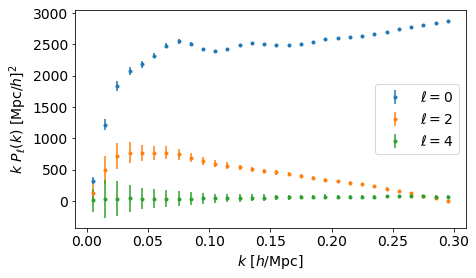

In [18]:
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.errorbar(kd, kd * bpk[i], yerr=kd*err[i], fmt='.', label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

### Creating the fake data

We are now ready to create our fake data. For that, we can use the build-in function in the ReadWrite class. 

In [19]:
io = ReadWrite()

The data structure is a dictionary. 

In [20]:
d = {}

Each sky corresponds to an entry in this dictionary, which is itself a dictionary containing the data. 

Here we have only one sky, and we name it 'sky_1'. 

In [21]:
d['sky_1'] = {}

We now start filling this dictionary with the data. 

In [22]:
zmin, zmax, zeff = 0.43, 0.7, z
io.write_common(d['sky_1'], zmin, zmax, zeff, Omega_m_fid, H_fid, D_fid)
print (d['sky_1']['z'].keys())
print (d['sky_1']['fid'].keys())

dict_keys(['min', 'max', 'eff'])
dict_keys(['Omega_m', 'H', 'D'])


In [23]:
mult_pk = 3
io.write_pk(d['sky_1'], mult_pk, kd, bpk, cov, nsims_cov_pk=0, 
            survey_mask_arr_p=None, survey_mask_mat_kp=None,
            binsize=dk)
print (d['sky_1']['bPk'].keys())

dict_keys(['multipole', 'x', 'cov', 'nsims', 'survey_mask', 'binsize', 'l0', 'l2', 'l4'])


Here we are not providing a survey mask. One can compute the survey mask from random catalogs using https://github.com/pierrexyz/fkpwin , in a format compatible with PyBird: 
```
survey_mask = np.load('output_fkpwin/Wlmkp_skyname.npz')
survey_mask_arr_p = survey_mask['p']
survey_mask_mat_kp = survey_mask['Wlm']
```
Also, there are two other build-in functions that we are not using here, feel free to explore!
    
```
io.write_cf(d_sky, mult_cf, ss, cf, cov_cf, nsims_cov_cf=0, binsize=None)
io.write_bao_rec(d_sky, bao_rec_rd_fid, bao_rec_H_fid, bao_rec_D_fid, alpha_par, alpha_per, 
                 cov_alpha, cov_cross_pk=None, cov_cross_cf=None)
```



Finally we save our fake data. 

In [24]:
np.save(os.path.join(datadir, 'fake', 'fake_example_2pt.npy'), d)

### Testing the fake data

Cool. Now let us test the fake data by maximazing the likelihood: do we recover the truth?

We first need a configuration file. Let us create one. 

In [25]:
configdir = os.path.join(datadir, 'eftboss', 'config')

For simplicity, let us load a configuration file and modify it accordingly. 

In [26]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_pk.yaml'), 'r'))
config["data_path"] = os.path.join(datadir, 'fake')
config["data_file"] = 'fake_example_2pt.npy'
config["multipole"] = 3
config["with_survey_mask"] = False
config["with_binning"] = True

config["sky"]['sky_1'] = config["sky"].pop('cmass_ngc')
config["sky"]['sky_1']['min'] = [0.01, 0.01, 0.01]
config["sky"]['sky_1']['max'] = [0.20, 0.20, 0.20]

config["write"]["fake"] = True
config["write"]["out_path"] = os.path.join(datadir, 'fake', 'out')
config["write"]["out_name"] = 'sky_1'

We center the prior on the truth for this check. 

In [27]:
for name, truth in eft_truth.items(): 
    if name != 'b1': 
        config["eft_prior"][name]['mean'] = [truth]

In [28]:
print ( yaml.dump(config, indent=4, sort_keys=False))

data_path: /Users/pierre/Documents/github/pybird/data/fake
data_file: fake_example_2pt.npy
output: bPk
multipole: 3
with_ap: true
with_survey_mask: false
sky:
    sky_1:
        min:
        - 0.01
        - 0.01
        - 0.01
        max:
        - 0.2
        - 0.2
        - 0.2
write:
    save: true
    fake: true
    plot: true
    show: true
    out_path: /Users/pierre/Documents/github/pybird/data/fake/out
    out_name: sky_1
km: 0.7
kr: 0.35
nd: 0.0003
eft_basis: eftoflss
with_stoch: true
eft_prior:
    b1:
        type: flat
        range: null
    b2:
        type: gauss
        mean:
        - 0.6067
        range:
        - 2.0
    b4:
        type: gauss
        mean:
        - 0.2212
        range:
        - 2.0
    b3:
        type: marg_gauss
        mean:
        - -0.2682
        range:
        - 2.0
    cct:
        type: marg_gauss
        mean:
        - 0.1366
        range:
        - 2.0
    cr1:
        type: marg_gauss
        mean:
        - -0.705
        rang

Let us setup the likelihood with this configuration. 

In [29]:
L = Likelihood(config)

reading data file: /Users/pierre/Documents/github/pybird/data/fake/fake_example_2pt.npy
-----------------------
sky: sky_1
output: bPk
multipole: 3
min bound (per multipole): [0.01, 0.01, 0.01]
max bound (per multipole): [0.2, 0.2, 0.2]
coordinate (AP) distortion: on
binning: on
-----------------------
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


We initialize the likelihood. 

In [30]:
eft_name = ['b1', 'b2', 'b4'] 
eft_init = [2, 0., 0.] 
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

We can now maximize the likelihood. 

In [31]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))

min chi2: 0.00, p-value: 1.000


Looks like we have recovered the truth ($\chi^2 = 0$)! Let us see how well we have recovered it: 

In [32]:
print ('- ratio fit/truth -')
for name, truth, fit in zip(eft_truth.keys(), eft_truth.values(), L.out[0]['eft_parameters'].values()):
    print ('%s: %.2f' % (name, fit/truth))

- ratio fit/truth -
b1: 1.00
b2: 1.01
b4: 0.99
b3: 1.01
cct: 0.98
cr1: 1.03
cr2: 0.97
ce0: 1.00
ce1: 0.95
ce2: 1.00


### Build-in fake data generator from best fit

By the way, did you know that there is a build-in function that can create fake data directly from a fit?

This happens if we set: ```config["write"]["fake"] = True``` and run the following function: 

fake data from best fit saved to /Users/pierre/Documents/github/pybird/data/fake.
data files with best fit saved to /Users/pierre/Documents/github/pybird/data/fake/out.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/fake/out.


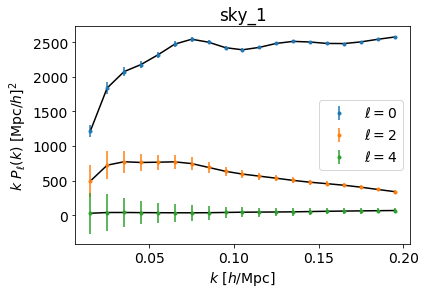

In [33]:
L.write()

Let us see if this is real! This is the automatically generated file from the previous minimization:

In [34]:
config["data_file"] = 'fake_sky_1.npy'

Let us try it.

In [35]:
L = Likelihood(config)

reading data file: /Users/pierre/Documents/github/pybird/data/fake/fake_sky_1.npy
-----------------------
sky: sky_1
output: bPk
multipole: 3
min bound (per multipole): [0.01, 0.01, 0.01]
max bound (per multipole): [0.2, 0.2, 0.2]
coordinate (AP) distortion: on
binning: on
-----------------------
-----------------------
get_maxlkl : True
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


In [36]:
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

In [37]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))

min chi2: 0.00, p-value: 1.000


Cool.